In [24]:
%load_ext autoreload
%autoreload 2
import sys
import os
sys.path.insert(0, os.path.abspath('..'))

from src.feature_engineer import load_encoder, rotation_feature_engineer, accelrometer_feature_engineer
from src.data_cleaning import clean_df, normalize_sequence_count
from src.utils.model_utils import evaulate_model, train_model
from scipy.signal import butter, filtfilt, find_peaks, welch
from src.utils.visualize_utils import plot_cm, get_avg_fold
from scipy.spatial.transform import Rotation
import lightgbm as lgb

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

import torch.nn as nn
import torch
from torch.utils.data import DataLoader, TensorDataset

from sklearn.model_selection import GroupKFold

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
raw_path = "../data/raw"
encoder_path = "../models/label_encoder.pkl"

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
# preprocess
full_df = pd.merge(
    left=pd.read_csv(os.path.join(raw_path, "train.csv")),
    right=pd.read_csv(os.path.join(raw_path, "train_demographics.csv")),
    on="subject",
    how="left",
)

tof_of_interest = ["tof_1_v20", "tof_2_v26", "tof_3_v17", "tof_4_v5", "tof_5_v20"]
full_df = full_df.drop(columns=[col for col in full_df.columns if col not in tof_of_interest and  col.startswith("tof_")])

full_df

,row_id,sequence_type,sequence_id,sequence_counter,subject,orientation,behavior,phase,gesture,acc_x,...,tof_3_v17,tof_4_v5,tof_5_v20,adult_child,age,sex,handedness,height_cm,shoulder_to_wrist_cm,elbow_to_wrist_cm
0,SEQ_000007_000000,Target,SEQ_000007,0,SUBJ_059520,Seated Lean Non Dom - FACE DOWN,Relaxes and moves hand to target location,Transition,Cheek - pinch skin,6.683594,...,57.0,-1.0,-1.0,0,12,1,1,163.0,52,24.0
1,SEQ_000007_000001,Target,SEQ_000007,1,SUBJ_059520,Seated Lean Non Dom - FACE DOWN,Relaxes and moves hand to target location,Transition,Cheek - pinch skin,6.949219,...,68.0,-1.0,-1.0,0,12,1,1,163.0,52,24.0
2,SEQ_000007_000002,Target,SEQ_000007,2,SUBJ_059520,Seated Lean Non Dom - FACE DOWN,Relaxes and moves hand to target location,Transition,Cheek - pinch skin,5.722656,...,97.0,107.0,-1.0,0,12,1,1,163.0,52,24.0
3,SEQ_000007_000003,Target,SEQ_000007,3,SUBJ_059520,Seated Lean Non Dom - FACE DOWN,Relaxes and moves hand to target location,Transition,Cheek - pinch skin,6.601562,...,151.0,113.0,-1.0,0,12,1,1,163.0,52,24.0
4,SEQ_000007_000004,Target,SEQ_000007,4,SUBJ_059520,Seated Lean Non Dom - FACE DOWN,Relaxes and moves hand to target location,Transition,Cheek - pinch skin,5.566406,...,207.0,121.0,192.0,0,12,1,1,163.0,52,24.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
574940,SEQ_065531_000048,Non-Target,SEQ_065531,48,SUBJ_039498,Seated Lean Non Dom - FACE DOWN,Performs gesture,Gesture,Write name on leg,3.503906,...,219.0,93.0,46.0,1,30,0,1,186.0,55,30.0
574941,SEQ_065531_000049,Non-Target,SEQ_065531,49,SUBJ_039498,Seated Lean Non Dom - FACE DOWN,Performs gesture,Gesture,Write name on leg,3.773438,...,216.0,82.0,50.0,1,30,0,1,186.0,55,30.0
574942,SEQ_065531_000050,Non-Target,SEQ_065531,50,SUBJ_039498,Seated Lean Non Dom - FACE DOWN,Performs gesture,Gesture,Write name on leg,3.082031,...,208.0,83.0,53.0,1,30,0,1,186.0,55,30.0
574943,SEQ_065531_000051,Non-Target,SEQ_065531,51,SUBJ_039498,Seated Lean Non Dom - FACE DOWN,Performs gesture,Gesture,Write name on leg,3.964844,...,210.0,91.0,48.0,1,30,0,1,186.0,55,30.0


In [ ]:
cleaned_df, target_gestures = clean_df(full_df, drop_rot_na=True, drop_thm_na=False) #, min_gesture_count=-1)
cleaned_df = normalize_sequence_count(cleaned_df)
cleaned_df = cleaned_df[cleaned_df['gesture'].isin(['Neck - scratch', 'Neck - pinch skin'])]

cleaned_df = rotation_feature_engineer(cleaned_df)
cleaned_df = accelrometer_feature_engineer (cleaned_df)

cleaned_df

[rot_na] Remaining: 254179/574945 (-320766, 55.8% dropped)
[gesture_len outliers] Remaining: 222934/254179 (-31245, 12.3% dropped)


,row_id,sequence_type,sequence_id,sequence_counter,subject,orientation,behavior,phase,gesture,acc_x,...,rotvec_x_diff,rotvec_z_diff,angular_mag,fft_acc_x,fft_acc_y,fft_acc_z,acc_mag,jerk_acc_x,jerk_acc_y,jerk_acc_z
210,SEQ_000033_000027,Target,SEQ_000033,27,SUBJ_040733,Lie on Back,Performs gesture,Gesture,Neck - scratch,-8.659965,...,0.000000,0.000000,0.000000,40989.0,96934.0,43804.0,17.103003,0.000000,0.000000,0.000000
211,SEQ_000033_000028,Target,SEQ_000033,28,SUBJ_040733,Lie on Back,Performs gesture,Gesture,Neck - scratch,-9.534228,...,0.014095,-0.105372,0.140021,375.0,72.0,428.0,16.804070,-0.874263,0.931507,0.213826
212,SEQ_000033_000029,Target,SEQ_000033,29,SUBJ_040733,Lie on Back,Performs gesture,Gesture,Neck - scratch,-9.543579,...,-0.009227,-0.032712,0.034409,131.0,16.0,58.0,16.415039,-0.009351,0.619542,-0.083027
213,SEQ_000033_000030,Target,SEQ_000033,30,SUBJ_040733,Lie on Back,Performs gesture,Gesture,Neck - scratch,-9.612695,...,-0.004816,0.014107,0.059752,14.0,12.0,8.0,17.564652,-0.069116,-2.009091,0.837333
214,SEQ_000033_000031,Target,SEQ_000033,31,SUBJ_040733,Lie on Back,Performs gesture,Gesture,Neck - scratch,-9.816565,...,0.056639,-0.015991,0.059330,72.0,3.0,69.0,16.783577,-0.203870,2.660647,-2.175962
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
252660,SEQ_065519_000083,Target,SEQ_065519,84,SUBJ_050642,Seated Straight,Performs gesture,Gesture,Neck - scratch,1.585986,...,0.000000,0.000000,0.000000,4.0,0.0,1.0,11.965586,0.000000,0.000000,0.000000
252661,SEQ_065519_000083,Target,SEQ_065519,85,SUBJ_050642,Seated Straight,Performs gesture,Gesture,Neck - scratch,1.585986,...,0.000000,0.000000,0.000000,9.0,0.0,3.0,11.965586,0.000000,0.000000,0.000000
252662,SEQ_065519_000083,Target,SEQ_065519,86,SUBJ_050642,Seated Straight,Performs gesture,Gesture,Neck - scratch,1.585986,...,0.000000,0.000000,0.000000,12.0,4.0,3.0,11.965586,0.000000,0.000000,0.000000
252663,SEQ_065519_000083,Target,SEQ_065519,87,SUBJ_050642,Seated Straight,Performs gesture,Gesture,Neck - scratch,1.585986,...,0.000000,0.000000,0.000000,13.0,0.0,3.0,11.965586,0.000000,0.000000,0.000000


In [27]:
feautures_of_interest = [
    "acc_x",
    "acc_y",
    "acc_z",
    "fft_acc_x",
    "fft_acc_y",
    "fft_acc_z",
    "acc_mag",
    "jerk_acc_x",
    "jerk_acc_y",
    "jerk_acc_z",
    "rotvec_x",
    "rotvec_y",
    "rotvec_z",
    "rot_angle",
    "angular_mag",
    # "tof_1_v20",
    # "thm_2",
    # "thm_4",
    # "thm_5",
]

sequence_groups = cleaned_df.groupby('sequence_id')
target_df = sequence_groups['gesture'].first()
encoder = load_encoder(encoder_path, target_df) # type: ignore


# full time lenght features
features_full_seq = np.array([group for _, group in sequence_groups[feautures_of_interest]], dtype=np.float32) # N x n_timesteps x n_features
features_full_seq = torch.tensor(features_full_seq.transpose(0, 2, 1).copy() )# N x n_features x n_timestpes

target_np = encoder.transform(target_df).astype(np.long) # type: ignore
target_tensor = torch.tensor(target_np)

target_gestures_encoded = torch.tensor(encoder.transform(target_df))

features_full_seq.shape, target_tensor.shape

(torch.Size([1173, 15, 35]), torch.Size([1173]))

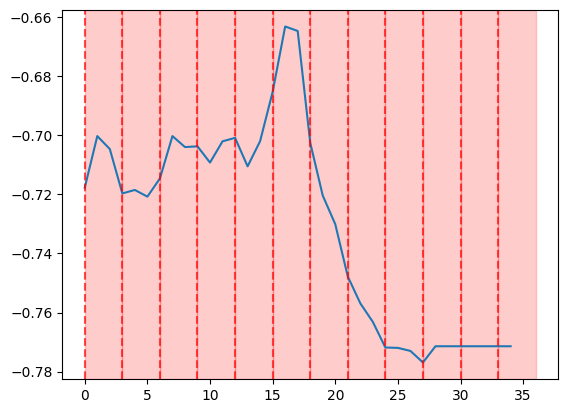

In [28]:
seq_to_plot =  cleaned_df['sequence_id'].unique()[0]
time_feature = cleaned_df[cleaned_df['sequence_id'] == seq_to_plot]['rot_x']

plt.plot(range(len(time_feature)), time_feature)
break_points = [0]

s = 3
k = 3
for i in range(0, len(time_feature), s):
    plt.axvline(x=i, color='r', linestyle='--', alpha=0.7)
    plt.axvspan(i, i+k, color='r', alpha=0.2)
    # break

In [29]:
class SimpleModel(nn.Module):
    def __init__(self, n_channels, n_classes):
        super().__init__()

        self.conv_layer = nn.Sequential(
            nn.Conv1d(n_channels, 12, kernel_size=3, stride=1, padding="same", bias=False),
            nn.BatchNorm1d(12),
            nn.ReLU(),
            nn.MaxPool1d(4),
            nn.Dropout(0.1),
            #
            nn.Conv1d(12, 32, kernel_size=3, stride=1, padding="same", bias=False),
            nn.BatchNorm1d(32),
            nn.ReLU(),
            nn.MaxPool1d(2),
            nn.Dropout(0.1),
            # #
            # nn.Conv1d(16, 8, kernel_size=3, stride=1, padding="same", bias=False),
            # nn.BatchNorm1d(8),
            # nn.ReLU(),
            # nn.MaxPool1d(2),
            # nn.Dropout(0.1),
            #
            nn.AdaptiveAvgPool1d(1),
        )

        self.fc = nn.Sequential(
            nn.Flatten(),
            nn.Linear(32, 32),
            nn.ReLU(),
            nn.Linear(32, n_classes),
        )

    def forward(self, x: torch.Tensor):
        """
        X shape: N x n_features x time_steps
        """
        x = self.conv_layer(x)  # x out_dim
        y_pred = self.fc(x)

        return y_pred


dummy_input = torch.rand(64, 15, 35)
dummy_model = SimpleModel(15, len(encoder.classes_))
dummy_model(dummy_input).shape

torch.Size([64, 2])

In [30]:
# FacePlant? aka what the fuck am i doing with my life
n_splits = 4
gkf = GroupKFold(n_splits)
subject_per_sequence = np.array([
    group.iloc[0] for _, group in sequence_groups['subject']
])

n_features = features_full_seq.shape[1]
batch_size = 33
n_epochs = 160

test_subjects = []
lgbm_folds_score = []
cnn_folds_score = []
importances = []

subject_per_sequence = np.array([
    group.iloc[0] for _, group in sequence_groups['subject']
])
for fold, (train_indices, test_indices) in enumerate(gkf.split(X=features_full_seq, y=target_tensor, groups=subject_per_sequence)): # type: ignore
    # ---Prepare
    print(f"\n------FOLD {fold + 1}/{n_splits}------\n")
    test_subjects.append(np.unique(subject_per_sequence[test_indices]))
    X_train, y_train = features_full_seq[train_indices], target_tensor[train_indices] # B x F x T
    X_test, y_test = features_full_seq[test_indices], target_tensor[test_indices]
    
    mean = X_train.mean(dim=(0, 2)).view(1, -1, 1)   # shape (1xFx1)
    std  = X_train.std(dim=(0, 2), unbiased=False).view(1, -1, 1) + 1e-8  # shape (1xFx1)

    # Normalize
    X_train = (X_train - mean) / (std + 1e-14)
    X_test  = (X_test  - mean) / (std + 1e-14)
    
    dataset_train = TensorDataset(X_train, y_train)
    dataloader_train = DataLoader(dataset_train, batch_size=batch_size, shuffle=True) # uh not sure if i should keep shuffle or no
    # ---End prepare
    
    model = SimpleModel(n_features, len(encoder.classes_)).to(device)
    model.train()
    train_model(model, dataloader_train, n_epochs, True)
    
    model.eval()
    y_pred = torch.argmax(model(X_test), dim=1)
    score_dashboard = evaulate_model(y_pred, y_test, target_gestures_encoded, encoder)
    cnn_folds_score.append(score_dashboard)


------FOLD 1/4------

0 - loss_avg: 0.6924312865292584
20 - loss_avg: 0.4684089885817634
40 - loss_avg: 0.4206980886282744
60 - loss_avg: 0.3543310617959058
80 - loss_avg: 0.34704938530921936
100 - loss_avg: 0.3302258059934334
120 - loss_avg: 0.30344263436617674
140 - loss_avg: 0.25200510052619157

------FOLD 2/4------

0 - loss_avg: 0.6834775319805851
20 - loss_avg: 0.4694025030842534
40 - loss_avg: 0.3879112093536942
60 - loss_avg: 0.3530734970613762
80 - loss_avg: 0.34322235319349503
100 - loss_avg: 0.27459921191136044
120 - loss_avg: 0.2689057033922937
140 - loss_avg: 0.2770422211399785

------FOLD 3/4------

0 - loss_avg: 0.6984997546231305
20 - loss_avg: 0.43869484464327496
40 - loss_avg: 0.3486756064273693
60 - loss_avg: 0.3225145836671193
80 - loss_avg: 0.3340603306337639
100 - loss_avg: 0.24787071540399833
120 - loss_avg: 0.2638554622729619
140 - loss_avg: 0.22230492753011208

------FOLD 4/4------

0 - loss_avg: 0.688949344334779
20 - loss_avg: 0.4924061187991389
40 - loss_av

CNN FOLD SCORE
macro: 0.735, binary: 1.000, competition: 0.868


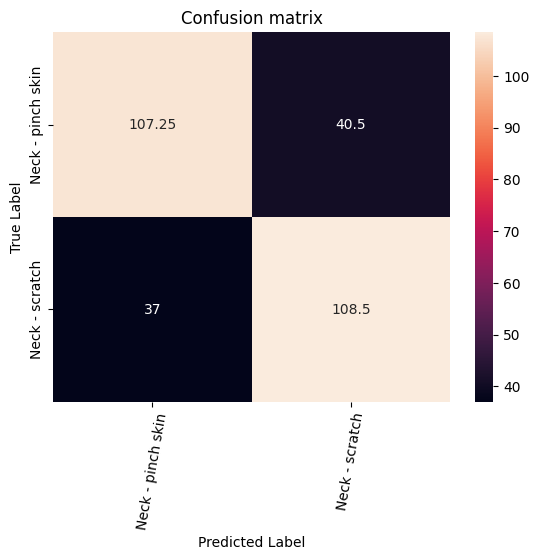

In [32]:
print("CNN FOLD SCORE")
fold_scores = cnn_folds_score
fold = get_avg_fold(fold_scores)

macro = fold["f1_macro"]
binary = fold["f1_binary"]

competition_eval = fold["competition_evaluation"]
cm = fold['confusion_matrix']

print(f'macro: {macro:.3f}, binary: {binary:.3f}, competition: {competition_eval:.3f}')

plot_cm(cm, list(encoder.classes_))
# fold["classification_report"]

In [55]:
print("LGBM FOLD SCORE")
fold_scores = lgbm_folds_score
fold = get_avg_fold(fold_scores)

macro = fold["f1_macro"]
binary = fold["f1_binary"]
competition_eval = fold["competition_evaluation"]
cm = fold['confusion_matrix']

print(f'macro: {macro:.3f}, binary: {binary:.3f}, competition: {competition_eval:.3f}')

plot_cm(cm, list(encoder.classes_))
fold["classification_report"]

LGBM FOLD SCORE


/home/zeyadcode/.pyenv/versions/aienv/lib/python3.12/site-packages/numpy/_core/fromnumeric.py:3904: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/zeyadcode/.pyenv/versions/aienv/lib/python3.12/site-packages/numpy/_core/_methods.py:147: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


ValueError: No objects to concatenate

['rotvec_x_mean', 'rotvec_x_std', 'rotvec_y_mean', 'rotvec_y_std', 'rotvec_z_mean', 'rotvec_z_std', 'rot_angle_mean', 'rot_angle_std', 'rotvec_x_diff_mean', 'rotvec_x_diff_std', 'rotvec_x_diff_min', 'rotvec_x_diff_max', 'rotvec_y_diff_mean', 'rotvec_y_diff_std', 'rotvec_y_diff_min', 'rotvec_y_diff_max', 'rotvec_z_diff_mean', 'rotvec_z_diff_std', 'rotvec_z_diff_min', 'rotvec_z_diff_max', 'angular_mag_mean', 'angular_mag_std', 'angular_mag_max', 'acc_x_mean', 'acc_x_std', 'acc_y_mean', 'acc_y_std', 'acc_z_mean', 'acc_z_std', 'acc_mag_mean', 'acc_mag_std', 'jerk_acc_x_mean', 'jerk_acc_x_std', 'jerk_acc_x_min', 'jerk_acc_x_max', 'jerk_acc_y_mean', 'jerk_acc_y_std', 'jerk_acc_y_min', 'jerk_acc_y_max', 'jerk_acc_z_mean', 'jerk_acc_z_std', 'jerk_acc_z_min', 'jerk_acc_z_max', 'fft_acc_x_mean', 'fft_acc_x_std', 'fft_acc_y_mean', 'fft_acc_y_std', 'fft_acc_z_mean', 'fft_acc_z_std', 'cnn_0', 'cnn_1', 'cnn_2', 'cnn_3', 'cnn_4', 'cnn_5', 'cnn_6', 'cnn_7', 'cnn_8', 'cnn_9', 'cnn_10', 'cnn_11', 'cnn_1

,feature,importance
20,angular_mag_mean,546.75
22,angular_mag_max,401.00
21,angular_mag_std,301.00


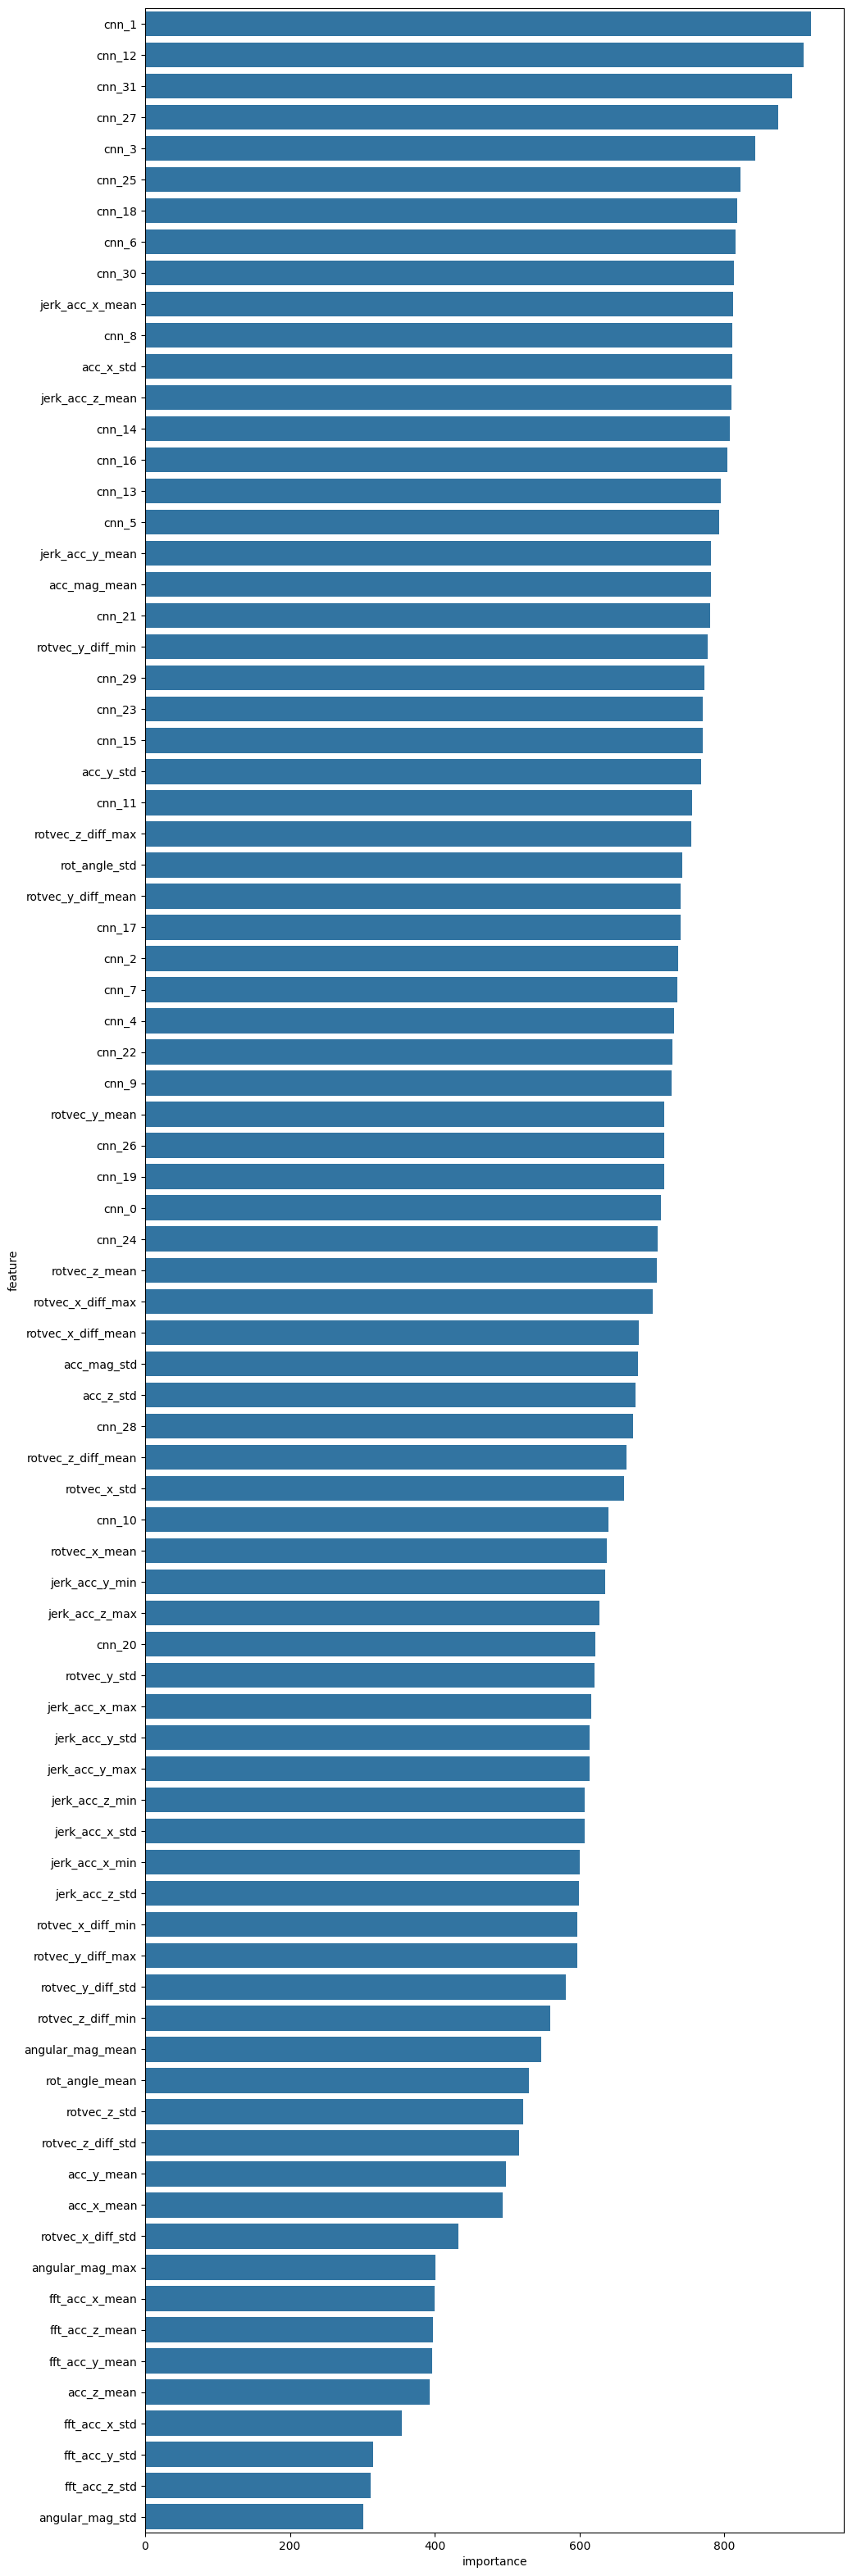

In [20]:
avg_importances =np.mean(importances, axis=0)

statistical_feature_names = filtered_df.drop(columns=["gesture_first", "subject_first"]).columns.tolist()
cnn_feature_names = [f"cnn_{i}" for i in range(avg_importances.shape[0] - len(statistical_feature_names))]
col_names = statistical_feature_names + cnn_feature_names
print(col_names)

importance_df = pd.DataFrame({
    'feature': col_names,
    'importance': avg_importances,
}).sort_values(by='importance', ascending=False)

plt.figure(figsize=(11, 40))
sns.barplot(importance_df, x='importance', y='feature')
plt.title("")

importance_df[importance_df['feature'].str.contains("angular")]

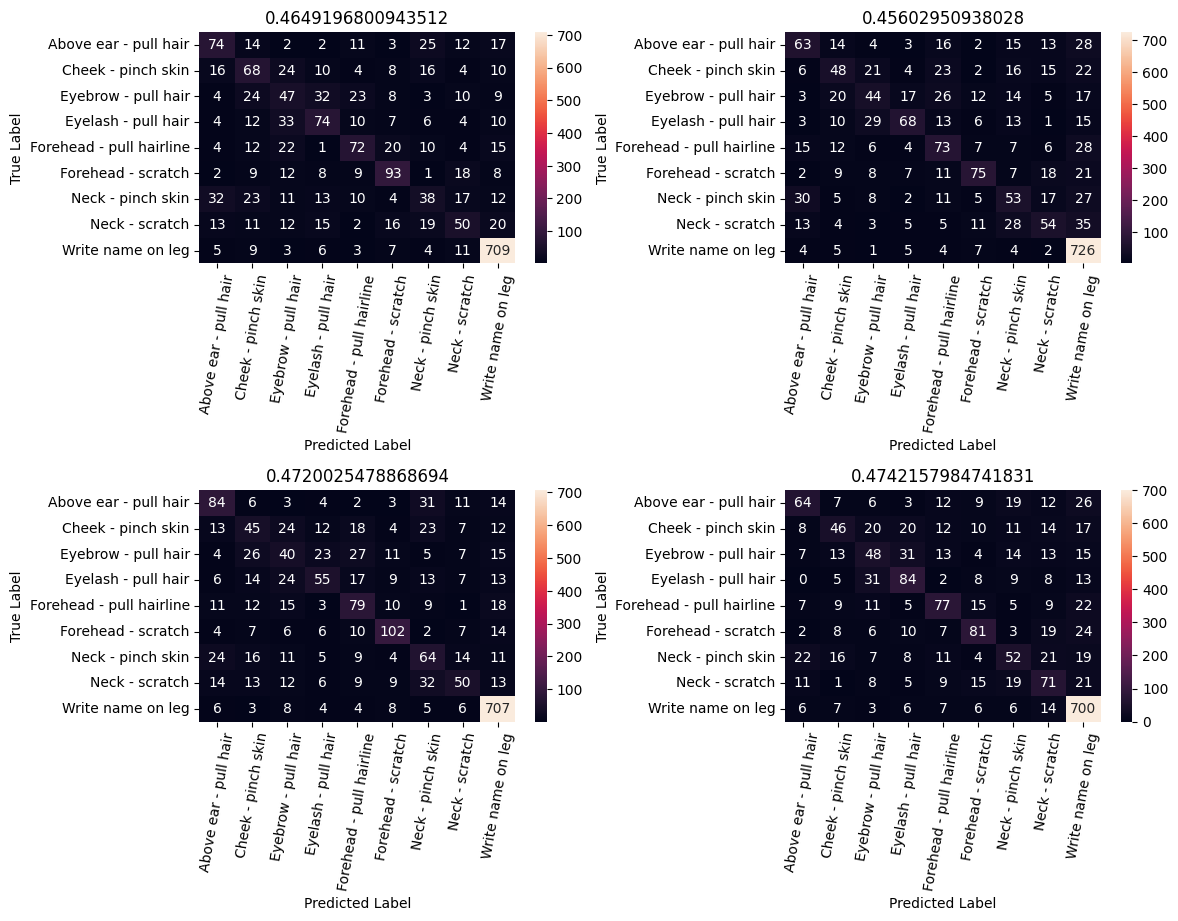

In [68]:
plt.figure(figsize=(12, 12))
for i, fold in enumerate(lgbm_folds_score, start=1):
    plt.subplot(3, 2, i)
    plot_cm(fold["confusion_matrix"], list(encoder.classes_))
    plt.title(fold['f1_macro'])

plt.tight_layout()
# plt.subplots_adjust(hspace=0.8)

([<matplotlib.axis.XTick at 0x74033cab0ef0>,
 [Text(0, 0, '0'), Text(1, 0, '1'), Text(2, 0, '2'), Text(3, 0, '3')])

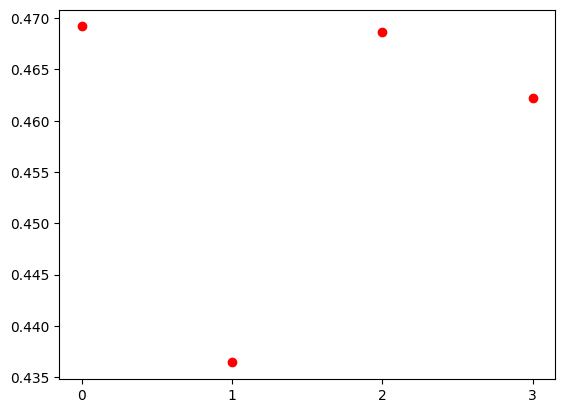

In [59]:
macros = [f["f1_macro"] for f in lgbm_folds_score]
plt.plot(np.arange(len(macros)), macros, 'ro')
plt.xticks(np.arange(len(macros)))

# bad_idx = 2
# good_idx = 4

# print(f'good subjects: {test_subjects[good_idx]}')
# print(f'bad subjects: {test_subjects[bad_idx]}')

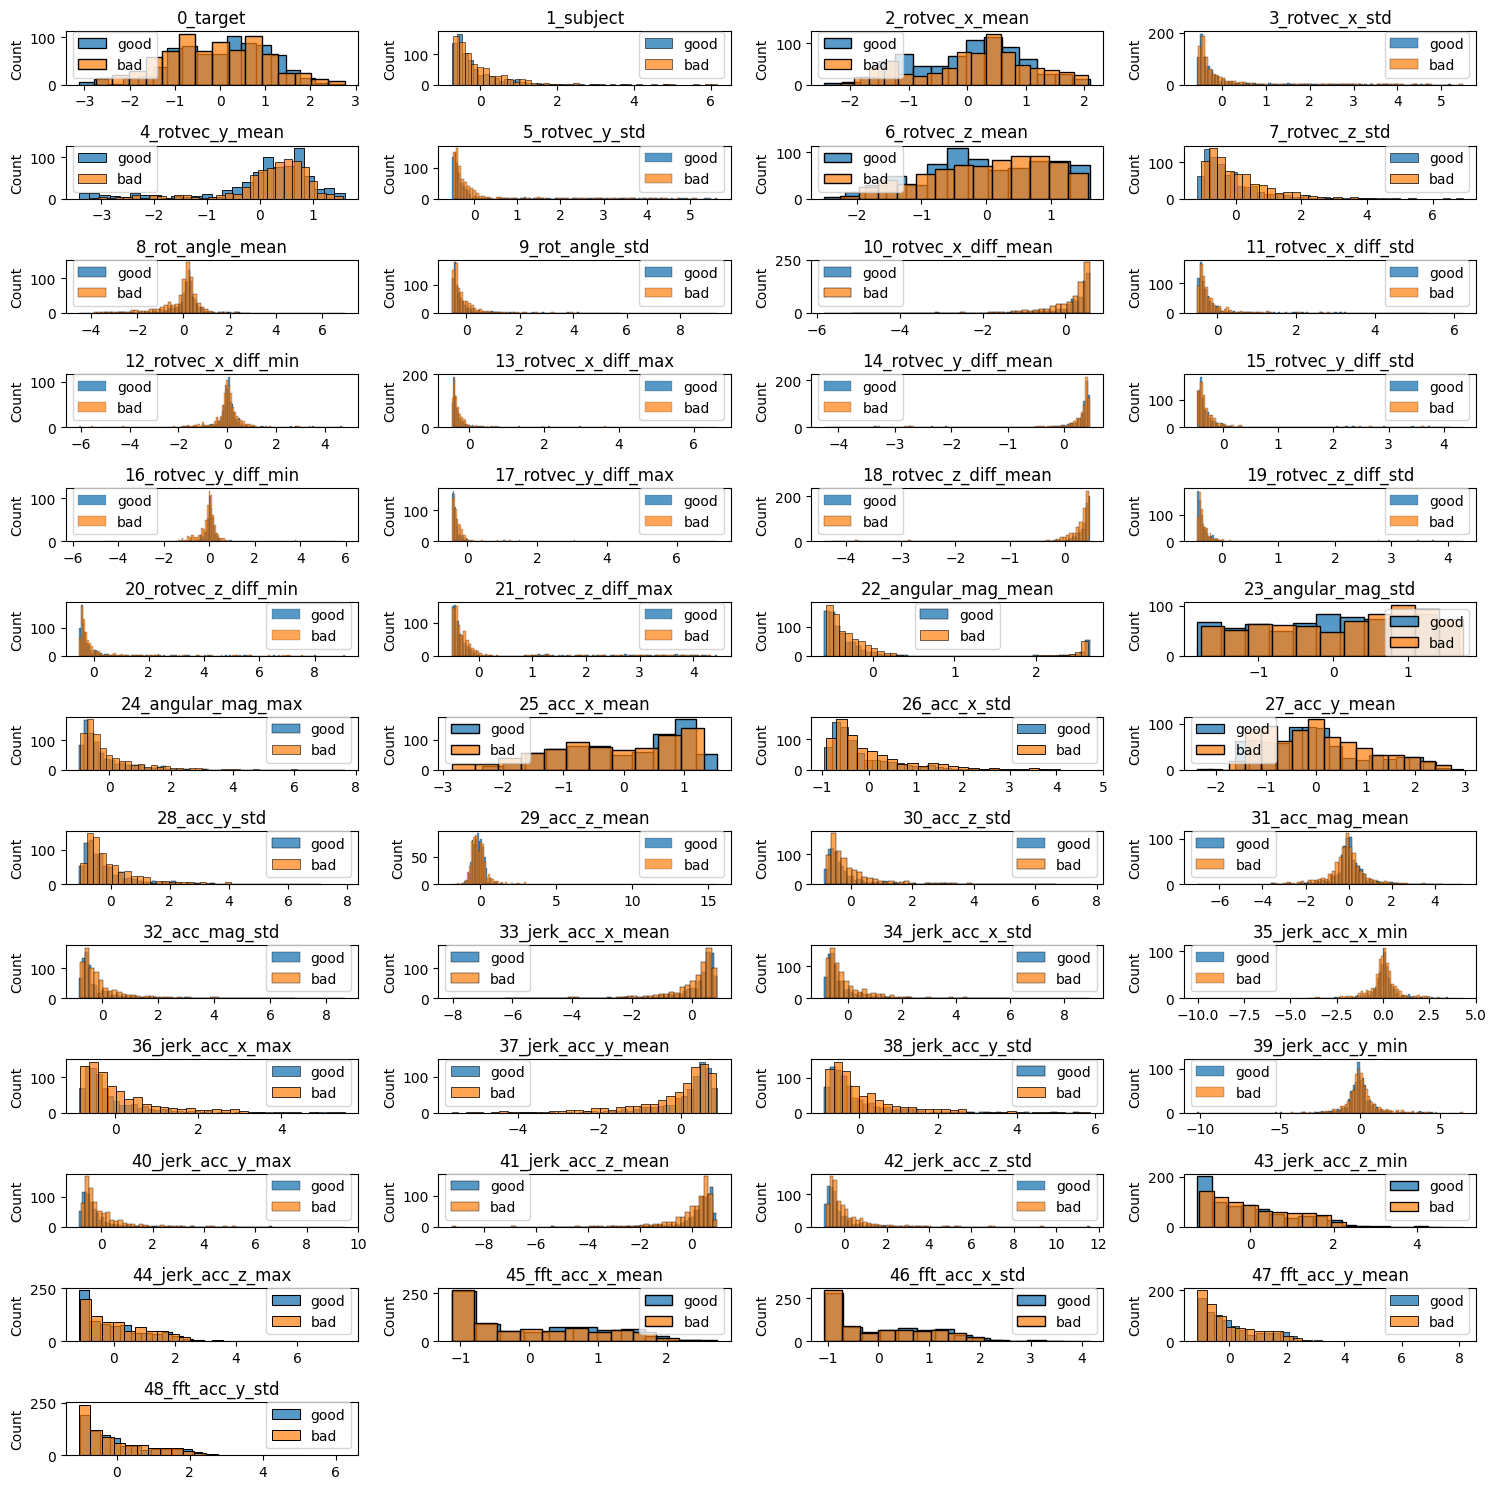

In [50]:
# sub_df = pd.DataFrame(
#     {
#         "value": np.concat([data_good, data_bad]),
#         "fold": ["good"] * len(data_good) + ["bad"] * len(data_bad),
#     }
# )


graph_idx = 1
plt.figure(figsize=(15, 15))
for feature_idx in range(0, X_train_arr[0].shape[1]):
    data_good = X_test_arr[good_idx][:, feature_idx]
    data_bad = X_test_arr[bad_idx][:, feature_idx]

    plt.subplot(13, 4, graph_idx)
    plt.title(f"{feature_idx}_{filtered_df.columns[feature_idx]}")
    sns.histplot(data_good, label="good")
    sns.histplot(data_bad, alpha=0.7, label="bad")
    plt.legend()

    graph_idx += 1

plt.tight_layout()

<Axes: ylabel='Count'>

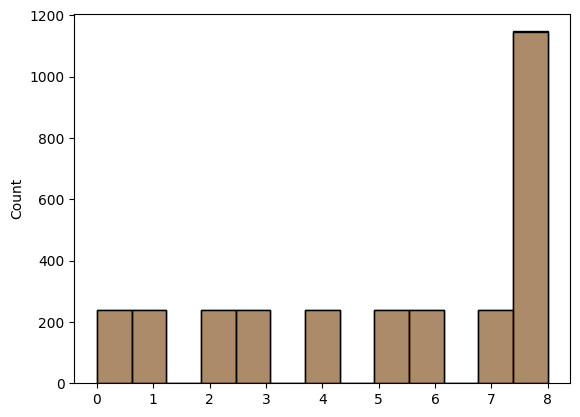

In [53]:
sns.histplot(y_train_arr[good_idx])
sns.histplot(y_train_arr[bad_idx], alpha=0.5)

In [ ]:
# final train model
n_epochs = 400
model = SimpleModel(len(encoder.classes_))

dataset_all = TensorDataset(features_tensor, target_tensor)
dataloader_all = DataLoader(dataset_all, batch_size=batch_size, shuffle=True)

train_model(model, dataloader_all, n_epochs, should_log=True)
torch.save(model.state_dict, '../models/model.pth')

0 - loss_avg: 1.7670864285901189
20 - loss_avg: 1.3435163935646415
40 - loss_avg: 1.2941331644542515
60 - loss_avg: 1.2580602089874446
80 - loss_avg: 1.2367916163057089
100 - loss_avg: 1.2189869447611272
120 - loss_avg: 1.2041548932902515
140 - loss_avg: 1.1891458523459733
160 - loss_avg: 1.1784265250898898
180 - loss_avg: 1.1631644000299275
200 - loss_avg: 1.1489455755800009
220 - loss_avg: 1.1393039487302303
240 - loss_avg: 1.130943219177425
260 - loss_avg: 1.1241767010651529
280 - loss_avg: 1.1117427400313318
300 - loss_avg: 1.1023416174575686
320 - loss_avg: 1.0911986152641475
340 - loss_avg: 1.0916559724137187
360 - loss_avg: 1.0821397854015231
380 - loss_avg: 1.0796014992520213
